# 6. Uncertainty Intervals 预测区间
默认情况下， Prophet 的返回结果中会包括预测值 **yhat** 的预测区间。当然，预测区间的估计需建立在一些重要的假设前提下。

在预测时，不确定性主要来源于三个部分：**趋势中的不确定性、季节效应估计中的不确定性和观测值的噪声影响**。

## 6.1 趋势的不确定性
预测中，不确定性最大的来源就在于未来趋势改变的不确定性。在之前的时间序列实例中，我们可以发现历史数据具有明显的趋势性。 Prophet 能够监测并去拟合它，但是我们期望得到的趋势改变究竟会如何走向呢？或许这是无解的，因此我们尽可能地做出最合理的推断，假定 “未来将会和历史具有相似的趋势” 。尤其重要的是，我们假定未来趋势的平均变动频率和幅度和我们观测到的历史值是一样的，从而预测趋势的变化并通过计算，最终得到预测区间。

这种衡量不确定性的方法具有以下性质：变化速率灵活性更大时（通过增大参数 **changepoint_prior_scale** 的值），预测的不确定性也会随之增大。原因在于如果将历史数据中更多的变化速率加入了模型，也就代表我们认为未来也会变化得更多，就会使得预测区间成为反映过拟合的标志。

预测区间的宽度（默认下，是 80% ）可以通过设置 **interval_width** 参数来控制：

In [1]:
from fbprophet import Prophet
import pandas as pd

df = pd.read_csv('examples/example_wp_log_peyton_manning.csv')
m = Prophet(interval_width=0.95).fit(df)
future = m.make_future_dataframe(periods=365)
forecast = m.predict(future)
pd.plotting.register_matplotlib_converters()
fig = m.plot(forecast)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
C:\Users\PC-00001\Miniconda3\lib\site-packages\pystan\misc.py:399: FutureWarning:

Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.



由于预测区间估计时假定未来将会和过去保持一样的变化频率和幅度，而这个假定可能并不正确，所以预测区间的估计不可能完全准确。 
## 6.2 季节的不确定性
默认情况下， Prophet 只会返回趋势中的不确定性和观测值噪声的影响。你必须使用**贝叶斯取样**的方法来得到季节效应的不确定性，可通过设置 **mcmc.samples** 参数（默认下取 0 ）来实现。下面使用佩顿 · 曼宁的数据为例：

In [2]:
m = Prophet(mcmc_samples=300)
forecast = m.fit(df).predict(future)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


上述代码将最大后验估计（ MAP ）取代为马尔科夫蒙特卡洛取样 （ MCMC ），并且将计算时间**从 10 秒延长到 10 分钟**。

如果做了全取样，就能通过绘图看到季节效应的不确定性了：

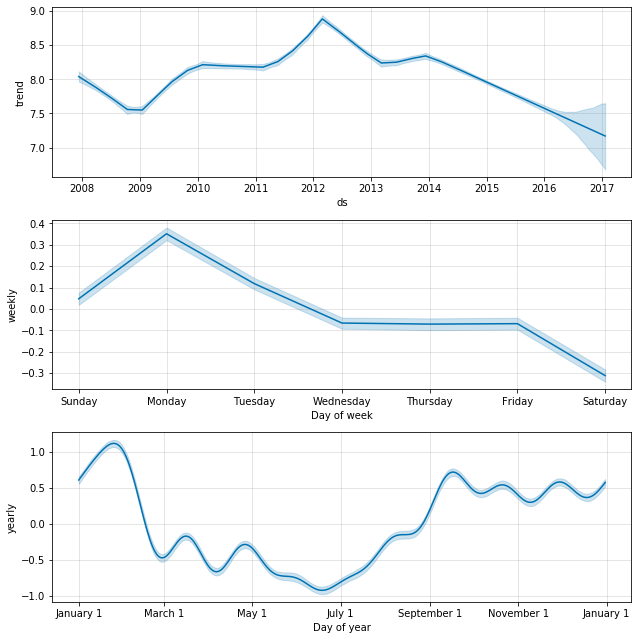

In [4]:
fig = m.plot_components(forecast)

可以使用**m.predictive_samples(future)**方法在Python中访问原始的后验预测样本。

在**PyStan有一些针对Windows的上游问题，这使得MCMC采样非常缓慢。在Windows中，MCMC采样的最佳选择是在Linux VM中使用R或Python**。

上述代码我在Windows电脑上实际用时为5022秒，也就是1个多小时！